# Proyek Analisis Sentimen (Data scrap aplikasi Duolingo)

# Import Library

In [ ]:
!pip install sastrawi
!pip install tensorflow
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

In [ ]:
# Import library untuk modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score
from sklearn.utils.class_weight import compute_class_weight

import csv
import requests
from io import StringIO

# Loading Data

In [ ]:
duo_review_df = pd.read_csv('https://raw.githubusercontent.com/Nadila-agustF/Proyek-Analisis-Sentimen-Dicoding/refs/heads/main/duo_apk_data.csv')
duo_review_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,e2f54c77-0551-43e5-aab7-60f5cb953713,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,untuk aplikasi nya seruu dan muda untuk di pah...,4,16,6.24.2,2025-04-03 22:46:54,NaN,NaN,6.24.2
1,558f02c7-4fa5-4086-b70d-4513b23bc989,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Duolingo memang baguss polll, aku suka banget....",3,15,6.24.2,2025-04-05 05:42:35,NaN,NaN,6.24.2
2,66d0f78c-3fb0-4a32-bee6-78b60d93afad,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Duolingo sudah mantap sebagai platform yang me...,5,136,6.23.2,2025-04-07 11:45:32,NaN,NaN,6.23.2
3,f826650b-7bb0-486d-bba8-0473e0e06876,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,ada beberapa kesalahan dari Duolingo 1 jawaban...,2,1,6.25.4,2025-04-14 08:20:02,NaN,NaN,6.25.4
4,9ac569b8-cf27-4ebf-ab32-c2fb60c1221f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,apk nya bagus tapi untuk sekarang saya kasih b...,2,3,6.24.2,2025-04-07 11:24:38,NaN,NaN,6.24.2


# Cleaning Data




In [ ]:
# Memeriksa Missing Value
duo_review_df.isnull().sum()

,0
reviewId,0
userName,0
userImage,0
content,0
score,0
thumbsUpCount,0
reviewCreatedVersion,751
at,0
replyContent,13500
repliedAt,13500


Note: Terdapat dua kolom yang kosong, tidak memiliki data sama sekali. Kemudian, nilai missing value lainnya terdapat pada dua kolom yang kurang relevan. Kolom yang diambil hanya 3 kolom yang relevan untuk model analisis sentimen

In [ ]:
 #Mengambil tiga kolom dataset
duo_review_df = duo_review_df[['content', 'score', 'thumbsUpCount']]
duo_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13500 entries, 0 to 13499
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        13500 non-null  object
 1   score          13500 non-null  int64 
 2   thumbsUpCount  13500 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 316.5+ KB


In [ ]:
duo_review_df.duplicated().sum()

np.int64(54)

Note: Terdapat duplikasi data sebanyak 54

In [ ]:
duo_review_df = duo_review_df.drop_duplicates()
print('Jumlah duplikasi: ', duo_review_df.duplicated().sum())

Jumlah duplikasi:  0


# Proprocessing Data

1. CleaningText(text): Membersihkan teks dengan menghapus mention, hashtag, RT (retweet), tautan (link), angka, dan tanda baca. Selain itu, karakter newline diganti dengan spasi dan spasi ekstra pada awal dan akhir teks dihapus.
2. TokenizingText(text): Memecah teks menjadi daftar kata atau token. Ini membantu dalam mengurai teks menjadi komponen-komponen dasar untuk analisis lebih lanjut.
3. FilteringText(text): Menghapus kata-kata berhenti (stopwords) dalam teks. Daftar kata-kata berhenti telah diperbarui dengan beberapa kata tambahan.
4. StemmingText(text): Menerapkan stemming pada teks, yakni mengurangi kata-kata menjadi bentuk dasarnya. Anda menggunakan pustaka Sastrawi untuk melakukan stemming dalam bahasa Indonesia.


In [ ]:
# Cleaning text
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    text = text.lower()
    return text

In [ ]:
# Menerapkan pada kolom content
duo_review_df['clean_content'] = duo_review_df['content'].apply(cleaningText)
duo_review_df[['content', 'clean_content']].head()

,content,clean_content
0,untuk aplikasi nya seruu dan muda untuk di pah...,untuk aplikasi nya seruu dan muda untuk di pah...
1,"Duolingo memang baguss polll, aku suka banget....",duolingo memang baguss polll aku suka banget y...
2,Duolingo sudah mantap sebagai platform yang me...,duolingo sudah mantap sebagai platform yang me...
3,ada beberapa kesalahan dari Duolingo 1 jawaban...,ada beberapa kesalahan dari duolingo jawaban ...
4,apk nya bagus tapi untuk sekarang saya kasih b...,apk nya bagus tapi untuk sekarang saya kasih b...


In [ ]:
# Tokenize Text
def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

# Filtering Text
def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy", "polll"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# Stemming Text
def stemmingText(text):
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

# To Sentences
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
# Create 'text_casefoldingText' column from 'clean_content'
duo_review_df['text_casefoldingText'] = duo_review_df['clean_content'] # Creating the missing column
duo_review_df[['content', 'clean_content', 'text_casefoldingText']].head() # check the added column

,content,clean_content,text_casefoldingText
0,untuk aplikasi nya seruu dan muda untuk di pah...,untuk aplikasi nya seruu dan muda untuk di pah...,untuk aplikasi nya seruu dan muda untuk di pah...
1,"Duolingo memang baguss polll, aku suka banget....",duolingo memang baguss polll aku suka banget y...,duolingo memang baguss polll aku suka banget y...
2,Duolingo sudah mantap sebagai platform yang me...,duolingo sudah mantap sebagai platform yang me...,duolingo sudah mantap sebagai platform yang me...
3,ada beberapa kesalahan dari Duolingo 1 jawaban...,ada beberapa kesalahan dari duolingo jawaban ...,ada beberapa kesalahan dari duolingo jawaban ...
4,apk nya bagus tapi untuk sekarang saya kasih b...,apk nya bagus tapi untuk sekarang saya kasih b...,apk nya bagus tapi untuk sekarang saya kasih b...


In [ ]:
slang_dict = {
    'gk': 'nggak',
    'ga': 'nggak',
    'ngga': 'nggak',
    'tdk': 'tidak',
    'bgt': 'banget',
    'bgtu': 'begitu',
    'sm': 'sama',
    'sbnrnya': 'sebenarnya',
    'aja': 'saja',
    'jg': 'juga',
    'udh': 'sudah',
    'blm': 'belum',
    'bsk': 'besok',
    'sy': 'saya',
    'dr': 'dari',
    'dgn': 'dengan',
    'tp': 'tapi',
    'krn': 'karena',
    'trs': 'terus',
    'kmrn': 'kemarin',
    'utk': 'untuk',
    'bkn': 'bukan',
    'pls': 'tolong',
    'btw': 'ngomong-ngomong',
    'wkwk': 'haha',
    'lol': 'haha',
    'omg': 'ya ampun',
    'mksh': 'terima kasih',
    'makasih': 'terima kasih',
    'trims': 'terima kasih',
    'thx': 'terima kasih',
    'dpt': 'dapat',
    'lg': 'lagi',
    'ny': 'nya',
    'nya': 'nya',
    'ntr': 'nanti',
    'ajaib': 'ajaib',
    'ngerti': 'mengerti',
    'bingungin': 'membingungkan',
}

def fix_slangwords(text):
    words = text.split()
    fixed_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(fixed_words)

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
duo_review_df['text_slangwords'] = duo_review_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
duo_review_df['text_tokenizingText'] = duo_review_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
duo_review_df['text_stopword'] = duo_review_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
duo_review_df['text_akhir'] = duo_review_df['text_stopword'].apply(toSentence)

In [ ]:
duo_review_df

,content,score,thumbsUpCount,clean_content,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,untuk aplikasi nya seruu dan muda untuk di pah...,4,16,untuk aplikasi nya seruu dan muda untuk di pah...,untuk aplikasi nya seruu dan muda untuk di pah...,untuk aplikasi nya seruu dan muda untuk di pah...,"[untuk, aplikasi, nya, seruu, dan, muda, untuk...","[aplikasi, seruu, muda, pahami, pengisian, cuo...",aplikasi seruu muda pahami pengisian cuore dit...
1,"Duolingo memang baguss polll, aku suka banget....",3,15,duolingo memang baguss polll aku suka banget y...,duolingo memang baguss polll aku suka banget y...,duolingo memang baguss polll aku suka banget y...,"[duolingo, memang, baguss, polll, aku, suka, b...","[duolingo, baguss, suka, banget, akhir², iklan...",duolingo baguss suka banget akhir² iklannya ik...
2,Duolingo sudah mantap sebagai platform yang me...,5,136,duolingo sudah mantap sebagai platform yang me...,duolingo sudah mantap sebagai platform yang me...,duolingo sudah mantap sebagai platform yang me...,"[duolingo, sudah, mantap, sebagai, platform, y...","[duolingo, mantap, platform, mengajarkan, baha...",duolingo mantap platform mengajarkan bahasa me...
3,ada beberapa kesalahan dari Duolingo 1 jawaban...,2,1,ada beberapa kesalahan dari duolingo jawaban ...,ada beberapa kesalahan dari duolingo jawaban ...,ada beberapa kesalahan dari duolingo jawaban s...,"[ada, beberapa, kesalahan, dari, duolingo, jaw...","[kesalahan, duolingo, seharus, disalahkan, yg,...",kesalahan duolingo seharus disalahkan yg b ing...
4,apk nya bagus tapi untuk sekarang saya kasih b...,2,3,apk nya bagus tapi untuk sekarang saya kasih b...,apk nya bagus tapi untuk sekarang saya kasih b...,apk nya bagus tapi untuk sekarang saya kasih b...,"[apk, nya, bagus, tapi, untuk, sekarang, saya,...","[apk, bagus, kasih, bintang, terkadang, macett...",apk bagus kasih bintang terkadang macettak buk...
...,...,...,...,...,...,...,...,...,...
13495,Ini ada unsur gl nya ya? Ku kira cuma 1 ternya...,4,0,ini ada unsur gl nya ya ku kira cuma ternyata...,ini ada unsur gl nya ya ku kira cuma ternyata...,ini ada unsur gl nya ya ku kira cuma ternyata ...,"[ini, ada, unsur, gl, nya, ya, ku, kira, cuma,...","[unsur, gl]",unsur gl
13496,"bagus, tapi kalok ngomong agak typo dikit",5,0,bagus tapi kalok ngomong agak typo dikit,bagus tapi kalok ngomong agak typo dikit,bagus tapi kalok ngomong agak typo dikit,"[bagus, tapi, kalok, ngomong, agak, typo, dikit]","[bagus, kalok, ngomong, typo, dikit]",bagus kalok ngomong typo dikit
13497,"Ngebug kah, kemarin saya udah selesaikan soal ...",3,4,ngebug kah kemarin saya udah selesaikan soal y...,ngebug kah kemarin saya udah selesaikan soal y...,ngebug kah kemarin saya udah selesaikan soal y...,"[ngebug, kah, kemarin, saya, udah, selesaikan,...","[ngebug, kemarin, udah, selesaikan, kali, noti...",ngebug kemarin udah selesaikan kali notif tant...
13498,Alhamdulillah dengan aplikasi ini kita jadi bi...,5,0,alhamdulillah dengan aplikasi ini kita jadi bi...,alhamdulillah dengan aplikasi ini kita jadi bi...,alhamdulillah dengan aplikasi ini kita jadi bi...,"[alhamdulillah, dengan, aplikasi, ini, kita, j...","[alhamdulillah, aplikasi, belajar, bahasa, ing...",alhamdulillah aplikasi belajar bahasa inggris ...


# Pelabelan

In [ ]:
# Memeriksa kata dan menghitung frekuensi
from collections import Counter

all_words = [word for tokens in duo_review_df['text_stopword'] for word in tokens]
word_freq = Counter(all_words)

for word, freq in word_freq.most_common(150):
    print(f"{word}: {freq}")

bahasa: 10720
belajar: 9673
bagus: 5548
duolingo: 5521
aplikasi: 5499
inggris: 5107
banget: 3634
membantu: 2496
yg: 2017
seru: 1698
nggak: 1498
suka: 1491
mudah: 1454
kasih: 1390
iklan: 1168
apk: 1154
aplikasinya: 979
tolong: 967
terima: 886
game: 884
asing: 854
udah: 829
kalo: 795
menyenangkan: 781
pemula: 742
terimakasih: 738
anak: 727
cocok: 689
pelajaran: 656
fitur: 645
karna: 642
bikin: 640
salah: 606
hati: 598
download: 578
gratis: 564
pokoknya: 548
jepang: 541
main: 541
orang: 535
deh: 532
pembelajaran: 531
bintang: 523
semangat: 507
keren: 477
bermanfaat: 475
semoga: 464
tau: 446
bermain: 439
pake: 433
pas: 433
berbahasa: 429
lancar: 424
latihan: 417
mengerti: 410
mempelajari: 402
menarik: 401
indonesia: 396
bhs: 390
gitu: 365
kadang: 363
belajarnya: 345
iklannya: 335
kayak: 332
senang: 320
biar: 317
app: 316
bug: 311
cepat: 310
pelajari: 299
berguna: 297
duo: 291
coba: 290
lumayan: 281
mohon: 280
dipahami: 280
gampang: 278
langsung: 270
pakai: 268
baguss: 260
perbaiki: 260
pah

In [ ]:
# Mengambil kamus kata positif
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

In [ ]:
lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")


In [ ]:
# Memeriksa kata yang tidak terdeteksi dalam kamus
known_words = set(lexicon_positive.keys()).union(set(lexicon_negative.keys()))
unknown_words = [word for word in all_words if word not in known_words]
print(f"Jumlah kata tidak dikenal: {len(set(unknown_words))}")

Jumlah kata tidak dikenal: 12778


In [ ]:
# Mengambil kata yang belum masuk kamus
all_words = [word for tokens in duo_review_df['text_stopword'] for word in tokens]
known_words = set(lexicon_positive.keys()).union(set(lexicon_negative.keys()))
unknown_words = [word for word in all_words if word not in known_words]

from collections import Counter
unknown_freq = Counter(unknown_words)

for word, freq in unknown_freq.most_common(100):
    print(f"{word}: {freq}")

duolingo: 5521
inggris: 5107
yg: 2017
iklan: 1168
apk: 1154
aplikasinya: 979
asing: 854
udah: 829
kalo: 795
pemula: 742
fitur: 645
karna: 642
bikin: 640
download: 578
jepang: 541
orang: 535
deh: 532
pembelajaran: 531
bintang: 523
keren: 477
semoga: 464
bermain: 439
pake: 433
berbahasa: 429
mempelajari: 402
indonesia: 396
bhs: 390
gitu: 365
belajarnya: 345
iklannya: 335
app: 316
bug: 311
pelajari: 299
duo: 291
dipahami: 280
pakai: 268
baguss: 260
perbaiki: 260
paham: 260
kali: 249
update: 249
cuman: 241
pintar: 239
teman: 237
lgbt: 235
best: 232
kosakata: 230
level: 224
klo: 224
diperbaiki: 217
developer: 213
korea: 207
bosan: 204
kosa: 201
b: 196
dasar: 193
unsur: 184
negara: 183
pahami: 182
kursus: 180
gw: 176
dll: 172
melatih: 171
hatinya: 170
tpi: 168
duolinggo: 167
dimengerti: 158
si: 156
ulang: 150
tuh: 148
meningkatkan: 148
dipelajari: 147
rekomendasi: 146
materi: 144
kedepannya: 139
apapun: 136
seruu: 135
nyawa: 134
animasi: 131
sulit: 128
bahasanya: 126
sekian: 126
binggris: 12

In [ ]:
def analysis_lexicon(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score += lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score += lexicon_negative[word]

        polarity = ''
    if score > 2:
        polarity = 'positif'
    elif score  < -3:
        polarity = 'negatif'
    else:
        polarity = 'netral'

    return score, polarity

In [ ]:
results = duo_review_df['text_stopword'].apply(analysis_lexicon)
results = list(zip(*results))
duo_review_df['polarity_score'] = results[0]
duo_review_df['polarity'] = results[1]
print(duo_review_df['polarity'].value_counts())

polarity
netral     5139
negatif    4789
positif    3518
Name: count, dtype: int64


In [ ]:
duo_review_df.sample(10)

,content,score,thumbsUpCount,clean_content,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir,polarity_score,polarity
5058,error lagi pemeliharaan server runtutan saya h...,5,0,error lagi pemeliharaan server runtutan saya h...,error lagi pemeliharaan server runtutan saya h...,error lagi pemeliharaan server runtutan saya h...,"[error, lagi, pemeliharaan, server, runtutan, ...","[error, pemeliharaan, server, runtutan, hangus]",error pemeliharaan server runtutan hangus,-8,negatif
798,"duolingo ini sangat bagus ,dan saya semakin me...",5,0,duolingo ini sangat bagus dan saya semakin men...,duolingo ini sangat bagus dan saya semakin men...,duolingo ini sangat bagus dan saya semakin men...,"[duolingo, ini, sangat, bagus, dan, saya, sema...","[duolingo, bagus, mengerti, bahasa, inggris, s...",duolingo bagus mengerti bahasa inggris semanga...,0,netral
5491,aku suka aplikasi ini karena aku bisa belajar ...,4,0,aku suka aplikasi ini karena aku bisa belajar ...,aku suka aplikasi ini karena aku bisa belajar ...,aku suka aplikasi ini karena aku bisa belajar ...,"[aku, suka, aplikasi, ini, karena, aku, bisa, ...","[suka, aplikasi, belajar, aplikasi, gitu]",suka aplikasi belajar aplikasi gitu,-3,netral
12819,game nya bagus banget aku sampai bisa bahasa i...,5,0,game nya bagus banget aku sampai bisa bahasa i...,game nya bagus banget aku sampai bisa bahasa i...,game nya bagus banget aku sampai bisa bahasa i...,"[game, nya, bagus, banget, aku, sampai, bisa, ...","[game, bagus, banget, bahasa, inggris, lancarr...",game bagus banget bahasa inggris lancarr banget,-2,netral
8296,sangat puas dan membuat saya lebih lancar berb...,5,0,sangat puas dan membuat saya lebih lancar berb...,sangat puas dan membuat saya lebih lancar berb...,sangat puas dan membuat saya lebih lancar berb...,"[sangat, puas, dan, membuat, saya, lebih, lanc...","[puas, lancar, berbahasa, inggris]",puas lancar berbahasa inggris,5,positif
12478,Sumpah gara gara apk ini sekarang aku jadi leb...,5,0,sumpah gara gara apk ini sekarang aku jadi leb...,sumpah gara gara apk ini sekarang aku jadi leb...,sumpah gara gara apk ini sekarang aku jadi leb...,"[sumpah, gara, gara, apk, ini, sekarang, aku, ...","[sumpah, gara, gara, apk, jago, bahasa, inggri...",sumpah gara gara apk jago bahasa inggrisnya ka...,-33,negatif
12344,Download app ini karena pengin main bareng ana...,2,5,download app ini karena pengin main bareng ana...,download app ini karena pengin main bareng ana...,download app ini karena pengin main bareng ana...,"[download, app, ini, karena, pengin, main, bar...","[download, app, pengin, main, bareng, anak, ap...",download app pengin main bareng anak appnya ud...,-6,negatif
2564,"sangattt baguss apk ini ,ini sangat membantu u...",5,0,sangattt baguss apk ini ini sangat membantu un...,sangattt baguss apk ini ini sangat membantu un...,sangattt baguss apk ini ini sangat membantu un...,"[sangattt, baguss, apk, ini, ini, sangat, memb...","[sangattt, baguss, apk, membantu, belajar, bah...",sangattt baguss apk membantu belajar bahasa asing,-1,netral
564,apk ini sangat keren membuat aku semakin seman...,5,1,apk ini sangat keren membuat aku semakin seman...,apk ini sangat keren membuat aku semakin seman...,apk ini sangat keren membuat aku semakin seman...,"[apk, ini, sangat, keren, membuat, aku, semaki...","[apk, keren, semangat, belajar, bahasa, reting...",apk keren semangat belajar bahasa reting aplik...,-3,netral
9230,Aplikasi ini sangat bagus bisa mengajarkan ban...,5,0,aplikasi ini sangat bagus bisa mengajarkan ban...,aplikasi ini sangat bagus bisa mengajarkan ban...,aplikasi ini sangat bagus bisa mengajarkan ban...,"[aplikasi, ini, sangat, bagus, bisa, mengajark...","[aplikasi, bagus, mengajarkan, bahasa, menamba...",aplikasi bagus mengajarkan bahasa menambah waw...,-16,negatif


# Explorasi Data Analysis

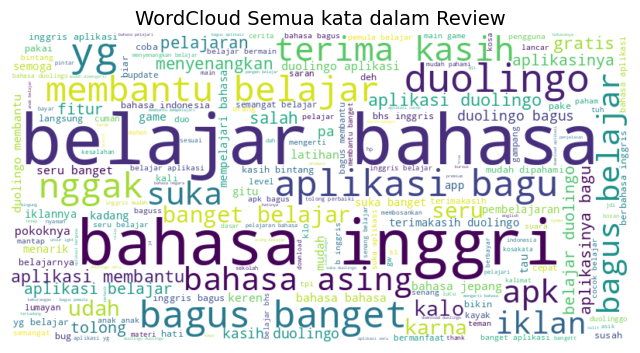

In [ ]:
text = ' '.join([' '.join(words) for words in duo_review_df['text_stopword']])

# Buat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Tampilkan
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Semua kata dalam Review", fontsize=14)
plt.show()

In [ ]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 300 karakter.
pd.set_option('display.max_colwidth', 300)

positif_tweets = duo_review_df[duo_review_df['polarity'] == 'positif'] # Megambil review dengan tweet positif
positif_tweets = positif_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
positif_tweets = positif_tweets.sort_values(by='polarity_score', ascending=False)
positif_tweets = positif_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
positif_tweets.index += 1

In [ ]:
# Mengatur tampilan agar kolom menampilkan teks 300 karakter
pd.set_option('display.max_colwidth', 300)
negatif_tweets = duo_review_df[duo_review_df['polarity'] == 'negatif'] # Megambil review dengan tweet negatif
negatif_tweets = negatif_tweets[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negatif_tweets = negatif_tweets.sort_values(by='polarity_score', ascending=True)
negatif_tweets = negatif_tweets[0:10]
negatif_tweets = negatif_tweets.reset_index(drop=True)

# Menambahkan 1 ke semua indeks DataFrame.
negatif_tweets.index += 1

In [ ]:
pd.set_option('display.max_colwidth', 300)

# Ambil review netral
netral_tweets = duo_review_df[duo_review_df['polarity'] == 'netral']

# Pilih kolom-kolom penting aja
netral_tweets = netral_tweets[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]

# Urutkan berdasarkan skor mendekati 0 (netral), jadi dari terkecil ke terbesar pakai nilai absolut
netral_tweets = netral_tweets.reindex(netral_tweets['polarity_score'].abs().sort_values().index)

# Reset index dan mulai dari 1
netral_tweets = netral_tweets.reset_index(drop=True)
netral_tweets.index += 1

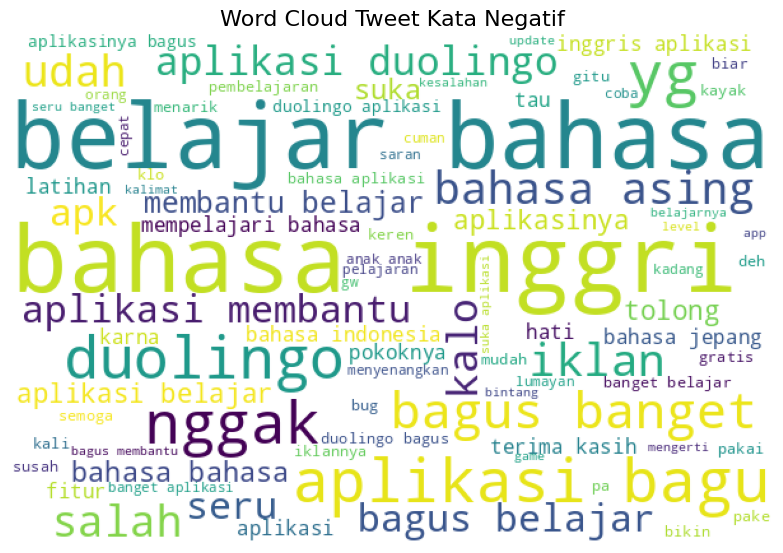

In [ ]:
list_words = ''

negatif_tweets = duo_review_df[duo_review_df['polarity'] == 'negatif']

for tweet in negatif_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud Tweet Kata Negatif', fontsize=16)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()


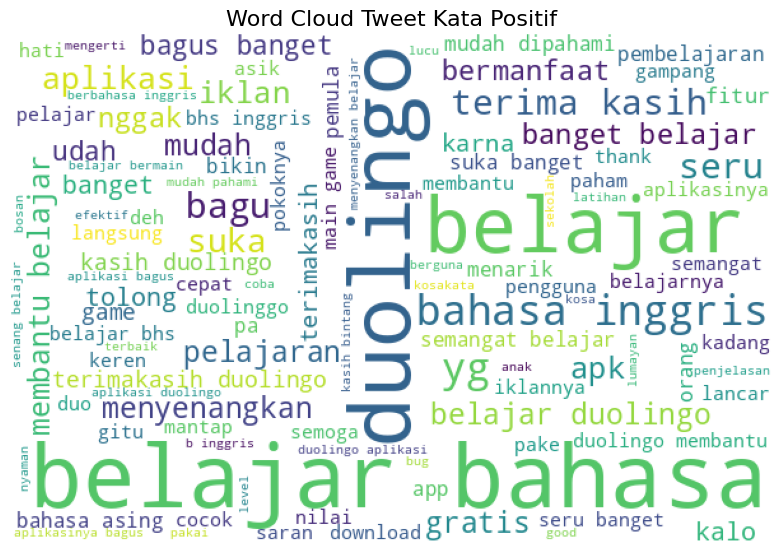

In [ ]:
list_words = ''

for tweet in positif_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud Tweet Kata Positif', fontsize=16)

ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

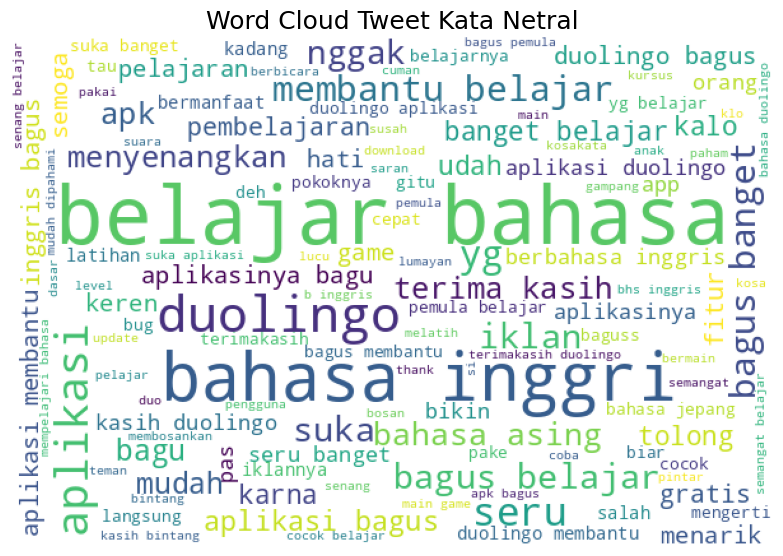

In [ ]:
list_words = ''

netral_tweets = duo_review_df[duo_review_df['polarity'] == 'netral']

for tweet in netral_tweets['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Word Cloud Tweet Kata Netral', fontsize=18)

ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')

plt.show()

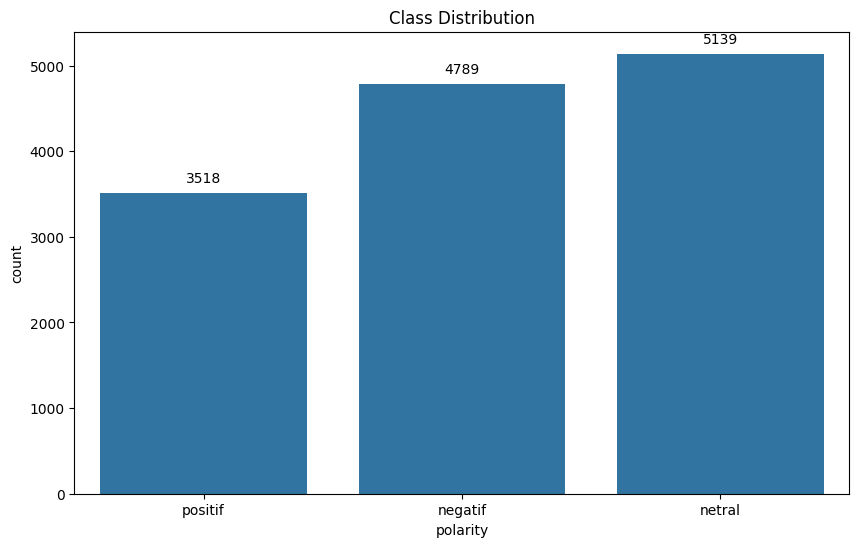

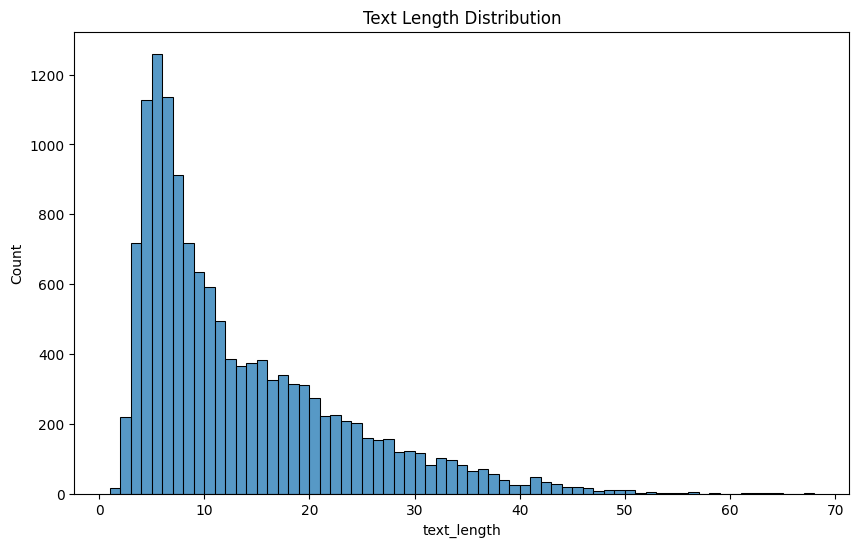

In [ ]:
# Grafik distribusi label dan kata
plt.figure(figsize=(10, 6))

# Memeriksa distribusi kelas
class_dist_plot = sns.countplot(x='polarity', data=duo_review_df)
plt.title('Class Distribution')

for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                              (p.get_x() + p.get_width() / 2., p.get_height()),
                              ha='center', va='center',
                              xytext=(0, 10),
                              textcoords='offset points')
plt.show()

plt.figure(figsize=(10, 6))

# Visualize distribusi panjang teks
duo_review_df['text_length'] = duo_review_df['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(duo_review_df['text_length'])
plt.title('Text Length Distribution')
plt.show()

<ipython-input-38-eae113363076>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette='mako')


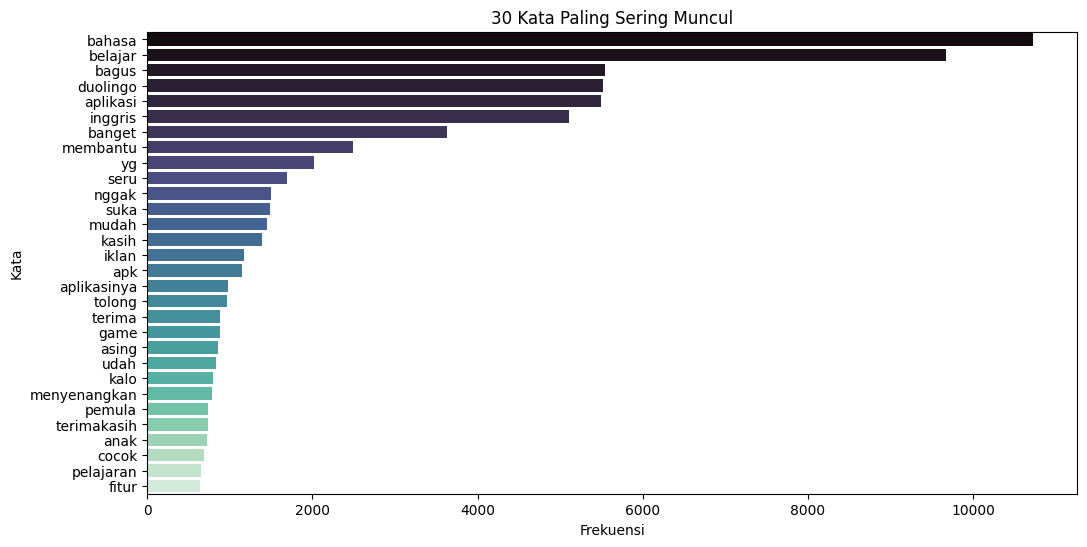

In [ ]:
# Melihat sebaran kata yang paling sering muncul
common_words = word_freq.most_common(30)

top_words = common_words[:30]
words, freqs = zip(*top_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(freqs), y=list(words), palette='mako')
plt.title('30 Kata Paling Sering Muncul')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()


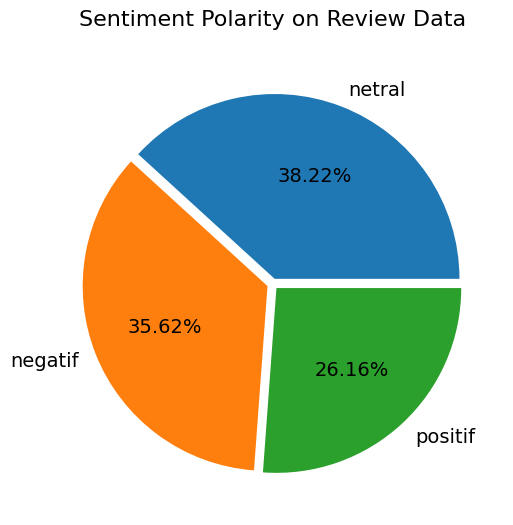

In [ ]:
# Melihat distribusi label
fig, ax = plt.subplots(figsize=(8, 6))
sizes = [count for  count in duo_review_df['polarity'].value_counts()]

labels = list(duo_review_df['polarity'].value_counts().index)
explode = (0.03, 0.03, 0.03)
ax.pie(x=sizes, labels=labels, autopct='%1.2f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)
plt.show()

# Feature Extraction & pelatihan model


### Skema 1
- Pelatihan: SVM
- Ekstraksi Fitur: TF-IDF
- Pembagian Data: 80/20

In [ ]:
duo_review_df['text_stopword'] = duo_review_df['text_stopword'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

tfidf = TfidfVectorizer(max_features=7000)
X = tfidf.fit_transform(duo_review_df['text_stopword'])

# Label encoding
label_map = {'positif': 2, 'netral': 1, 'negatif': 0}
y = duo_review_df['polarity'].map(label_map)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Evaluation
y_pred = svm_model.predict(X_test)
print("SVM + TF-IDF:\n", classification_report(y_test, y_pred))

SVM + TF-IDF:
               precision    recall  f1-score   support

           0       0.88      0.82      0.85       951
           1       0.73      0.83      0.77      1047
           2       0.86      0.76      0.81       692

    accuracy                           0.81      2690
   macro avg       0.82      0.80      0.81      2690
weighted avg       0.81      0.81      0.81      2690



### Skema 2
- Pelatihan: LSTM +Tokenizer
- Ekstraksi Fitur: TF-IDF
- Pembagian Data: 80/20  

In [ ]:
# Data Split
X = duo_review_df['text_akhir']
y = duo_review_df['polarity']

# Encode label
le = LabelEncoder()
y_encode = le.fit_transform(y)
y_cat = to_categorical(y_encode)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

# Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

# Hitung class weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_cat, axis=1)), y=np.argmax(y_cat, axis=1))
class_weights_dict = dict(enumerate(class_weights))

print("X_train_pad shape:", X_train_pad.shape)
print("X_test_pad shape:", X_test_pad.shape)

# Model LSTM
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, validation_split=0.2, epochs=5, batch_size=128,
                    class_weight=class_weights_dict, callbacks=[early_stop], verbose=1)

# Evaluate on Train and Test
train_loss, train_acc = model.evaluate(X_train_pad, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"LSTM - Train Accuracy: {train_acc:.4f}")
print(f"LSTM - Test Accuracy: {test_acc:.4f}")

X_train_pad shape: (10756, 100)
X_test_pad shape: (2690, 100)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 52s 695ms/step - accuracy: 0.4611 - loss: 1.0225 - val_accuracy: 0.7560 - val_loss: 0.6080
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 46s 682ms/step - accuracy: 0.7943 - loss: 0.4739 - val_accuracy: 0.8494 - val_loss: 0.3968
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 44s 655ms/step - accuracy: 0.9077 - loss: 0.2306 - val_accuracy: 0.8606 - val_loss: 0.3829
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 47s 695ms/step - accuracy: 0.9427 - loss: 0.1557 - val_accuracy: 0.8699 - val_loss: 0.4112
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 81s 681ms/step - accuracy: 0.9556 - loss: 0.1210 - val_accuracy: 0.8573 - val_loss: 0.4888
LSTM - Train Accuracy: 0.9411
LSTM - Test Accuracy: 0.8632


### Skema 3
- Pelatihan: RF   
- Ekstraksi Fitur: TF-IDF   
- Pembagian Data: 70/30    

In [ ]:
X = duo_review_df['text_stopword'].astype(str)  # Ubah ke string supaya TF-IDF gak error
y = duo_review_df['polarity']

tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Akurasi: 0.7332672285572632
Laporan Klasifikasi:
               precision    recall  f1-score   support

     negatif       0.73      0.82      0.77      1437
      netral       0.69      0.70      0.69      1542
     positif       0.83      0.66      0.74      1055

    accuracy                           0.73      4034
   macro avg       0.75      0.73      0.73      4034
weighted avg       0.74      0.73      0.73      4034



### Kesimpulan
Dari ketiga skema percobaan, pelatihan LSTM +Tokenizer dengan ekstraksi Fitur: TF-IDF menghasilkan akurasi yang lebih baik dari yang lain.

In [ ]:
!pip freeze > requirements.txt